.. _hadronic_pp_jet_guide:

In [1]:
def get_component(j_name,nu_name):
    j_nu_ptr=getattr(j._blob,j_name)
    nu_ptr=getattr(j._blob,nu_name)
    xg=np.zeros(j._blob.nu_grid_size)
    yg=np.zeros(j._blob.nu_grid_size)
    for i in range(j._blob.nu_grid_size):
        xg[i]=jetkernel.get_spectral_array(nu_ptr,j._blob,i)
        yg[i]=jetkernel.get_spectral_array(j_nu_ptr,j._blob,i)
    
    m=yg>0

    xg=xg[m]
    yg=yg[m]
    yg=yg*xg
    yg=yg*jetkernel.erg_to_TeV

    xg=xg*jetkernel.HPLANCK_TeV
    
    return xg,yg



# Jet pp Consistency with Kelner 2006

In [26]:
from jetset.jet_model import Jet
from jetset.jetkernel import jetkernel
from astropy import constants as const
from jetset.jet_emitters_factory import EmittersFactory
from jetset.jet_emitters import InjEmittersArrayDistribution


In [27]:
import jetset
print('tested on jetset',jetset.__version__)

tested on jetset 1.2.0rc4


In [28]:
j=Jet(emitters_distribution='plc',verbose=False,emitters_type='protons')

In [29]:

j.parameters.z_cosm.val=z=0.001
j.parameters.beam_obj.val=1
j.parameters.gamma_cut.val=1000/(jetkernel.MPC2_TeV)
j.parameters.NH_pp.val=1
j.parameters.N.val=1
j.parameters.p.val=2.0
j.parameters.B.val=1.0
j.parameters.R.val=1E18
j.parameters.gmin.val=1
j.parameters.gmax.val=1E4
j.set_emiss_lim(1E-60)
j.set_IC_nu_size(100)
j.gamma_grid_size=200



In [30]:
gamma_sec_evovled=np.copy(j.emitters_distribution.gamma_e)
n_gamma_sec_evovled=np.copy(j.emitters_distribution.n_gamma_e)
gamma_sec_inj=np.copy(j.emitters_distribution.gamma_e_second_inj)
n_gamma_sec_inj=np.copy(j.emitters_distribution.n_gamma_e_second_inj)

In [31]:
%matplotlib widget
j.emitters_distribution.plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [32]:
gmin=1.0/jetkernel.MPC2_TeV
j.set_N_from_U_emitters(1.0, gmin=gmin)
j.eval()

#j.show_model()

m=j.emitters_distribution.gamma_p>gmin
print('U N(p) p>1 TeV=%e erg/cm-3'%(jetkernel.MPC2*np.trapz(j.emitters_distribution.n_gamma_p[m]*j.emitters_distribution.gamma_p[m],j.emitters_distribution.gamma_p[m])))

U N(p) p>1 TeV=9.869680e-01 erg/cm-3


In [ ]:
%matplotlib widget
j.emitters_distribution.plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [10]:
q_inj=InjEmittersArrayDistribution(name='array_distr',emitters_type='electrons',gamma_array=gamma_sec_inj,n_gamma_array=n_gamma_sec_inj,normalize=False)

In [11]:
q_inj.parameters

name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
gmin,low-energy-cut-off,lorentz-factor*,2.000000e+00,1.000000e+00,1.000000e+09,False,False
gmax,high-energy-cut-off,lorentz-factor*,1.836150e+09,1.000000e+00,1.000000e+15,False,False
Q,emitters_density,1 / (cm3 s),1.000000e+00,0.000000e+00,--,False,False


None

In [12]:
%matplotlib widget
p=q_inj.plot()
p.ax.plot(np.log10(gamma_sec_inj),np.log10(n_gamma_sec_inj),'.')



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ipython-input-12-516781b9a646>:3: RuntimeWarning: divide by zero encountered in log10
  p.ax.plot(np.log10(gamma_sec_inj),np.log10(n_gamma_sec_inj),'.')


In [13]:
from jetset.jet_timedep import JetTimeEvol

temp_ev_acc=JetTimeEvol(jet=j,Q_inj=q_inj,inplace=True)

/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/jet_timedep.py:24: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [14]:
duration=1E7
duration_acc=0
T_SIZE=np.int(5E5)

temp_ev_acc.parameters.duration.val=duration
temp_ev_acc.parameters.TStart_Acc.val=0
temp_ev_acc.parameters.TStop_Acc.val=duration_acc
temp_ev_acc.parameters.TStart_Inj.val=0
temp_ev_acc.parameters.TStop_Inj.val=duration
temp_ev_acc.parameters.T_esc.val= 1
temp_ev_acc.parameters.t_D0.val=4000
temp_ev_acc.parameters.t_A0.val=2000
temp_ev_acc.parameters.Esc_Index.val=0
temp_ev_acc.parameters.Acc_Index.val=1
temp_ev_acc.parameters.Diff_Index.val=2
temp_ev_acc.parameters.T_SIZE.val=T_SIZE
temp_ev_acc.parameters.NUM_SET.val=200
temp_ev_acc._temp_ev.do_Compton_cooling=0
temp_ev_acc.parameters.L_inj.val=0
temp_ev_acc.parameters.LOG_SET.val=0

temp_ev_acc.parameters.gmin_grid.val=1.1
temp_ev_acc.parameters.gmax_grid.val=5E7
temp_ev_acc.parameters.gamma_grid_size.val=1000
temp_ev_acc.init_TempEv()

temp_ev_acc.show_model()

--------------------------------------------------------------------------------
JetTimeEvol model description
--------------------------------------------------------------------------------
 
physical setup: 

--------------------------------------------------------------------------------


name,par type,val,units,val*,units*,log
delta t,time,20.0,s,5.99584916e-07,R/c,False
R/c,time,33356409.519815207,s,1.0,R/c,False
Diff coeff,,0.00025,s-1,None,,False
Acc coeff,,0.0005,s-1,None,,False
Diff index,,2.0,,None,,False
Acc index,,1.0,s-1,None,,False
Tesc,time,33356409.519815207,s,1.0,R/c,False
T_A0=1/ACC_COEFF,time,2000.0,s,5.99584916e-05,R/c,False
T_D0=1/DIFF_COEFF,time,4000.0,s,0.0001199169832,R/c,False
T_DA0=1/(2*DIFF_COEFF),time,2000.0,s,5.99584916e-05,R/c,False



model parameters: 

--------------------------------------------------------------------------------


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_time_ev,duration,time_grid,s,1.000000e+07,0.000000e+00,--,False,True
jet_time_ev,gmin_grid,gamma_grid,,1.100000e+00,0.000000e+00,--,False,True
jet_time_ev,gmax_grid,gamma_grid,,5.000000e+07,0.000000e+00,--,False,True
jet_time_ev,gamma_grid_size,gamma_grid,,1.000000e+03,0.000000e+00,--,False,True
jet_time_ev,TStart_Acc,time_grid,s,0.000000e+00,0.000000e+00,--,False,True
jet_time_ev,TStop_Acc,time_grid,s,0.000000e+00,0.000000e+00,--,False,True
jet_time_ev,TStart_Inj,time_grid,s,0.000000e+00,0.000000e+00,--,False,True
jet_time_ev,TStop_Inj,time_grid,s,1.000000e+07,0.000000e+00,--,False,True
jet_time_ev,T_esc,escape_time,(R/c)*,1.000000e+00,--,--,False,True
jet_time_ev,Esc_Index,fp_coeff_index,,0.000000e+00,--,--,False,True


In [15]:
p=temp_ev_acc.plot_pre_run_plot(dpi=100)
p.ax.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [16]:
p=temp_ev_acc.plot_time_profile()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [17]:
temp_ev_acc.run(only_injection=True)


temporal evolution running


  0%|          | 0/500000 [00:00<?, ?it/s]

temporal evolution completed


In [21]:
p=temp_ev_acc.plot_TempEv_emitters(loglog=False,energy_unit='gamma',pow=0)
p.ax.plot(gamma_sec_evovled,n_gamma_sec_evovled,'.')
p.ax.plot(gamma_sec_inj,n_gamma_sec_inj,'.')
p.ax.axvline(temp_ev_acc._temp_ev.gamma_eq_t_A, ls='--')
p.ax.axvline(temp_ev_acc._temp_ev.gamma_eq_t_D, ls='--')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [22]:
%matplotlib notebook
p=j.plot_model()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [23]:
p=temp_ev_acc.plot_TempEv_emitters(loglog=False,energy_unit='gamma',pow=1)
p.ax.axvline(temp_ev_acc._temp_ev.gamma_eq_t_A, ls='--')
p.ax.axvline(temp_ev_acc._temp_ev.gamma_eq_t_D, ls='--')
#p.rescale(x_max=1E8,x_min=1,y_min=1E-4,y_max=1E4)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [24]:
j.emitters_distribution.n_gamma_e_second_inj

array([3.04434782e-19, 3.60543784e-19, 4.21202154e-19, 4.98722657e-19,
       5.82495124e-19, 6.89507000e-19, 8.05090488e-19, 9.52654510e-19,
       1.11193954e-18, 1.31515579e-18, 1.53434581e-18, 1.81375180e-18,
       2.11483959e-18, 2.49824623e-18, 2.91093793e-18, 3.43580466e-18,
       3.99998901e-18, 4.71644505e-18, 5.48530311e-18, 6.45990244e-18,
       7.50371891e-18, 8.82397629e-18, 1.02346538e-17, 1.20142888e-17,
       1.39104269e-17, 1.62950619e-17, 1.88272332e-17, 2.19999683e-17,
       2.53554531e-17, 2.95412339e-17, 3.39469199e-17, 3.94139093e-17,
       4.51352941e-17, 5.21904911e-17, 5.95237270e-17, 6.84988861e-17,
       7.77516380e-17, 8.89742287e-17, 1.00429914e-16, 1.14172647e-16,
       1.28031733e-16, 1.44433648e-16, 1.60725834e-16, 1.79679267e-16,
       1.98143279e-16, 2.19146970e-16, 2.39083972e-16, 2.61078595e-16,
       2.81207191e-16, 3.02443138e-16, 3.20824331e-16, 3.38863935e-16,
       3.53014456e-16, 3.65014095e-16, 3.72337635e-16, 3.75710232e-16,
      

In [25]:
#Fig 12 Kelner 2006
%matplotlib widget


#j_nu_pp rate
xg,yg= get_component('j_pp_gamma','nu_pp_gamma')
x_nu_e,y_nu_e= get_component('j_pp_neutrino_e','nu_pp_neutrino_e')
x_nu_mu,y_nu_mu= get_component('j_pp_neutrino_mu','nu_pp_neutrino_mu')
x_nu_tot,y_nu_tot= get_component('j_pp_neutrino_tot','nu_pp_neutrino_tot')
x_nu_mu_2=x_nu_mu
y_nu_2=(y_nu_tot-y_nu_mu)*np.pi*4
x_nu_mu_1=x_nu_mu
y_nu_mu_1=(y_nu_mu-y_nu_2)*np.pi*4

yg=yg*np.pi*4
y_nu_mu=y_nu_mu*np.pi*4
y_nu_e=y_nu_e*np.pi*4
#e-  rate
x_inj=np.copy(j.emitters_distribution.gamma_e_second_inj)
y_inj=np.copy(j.emitters_distribution.n_gamma_e_second_inj)
y_e=y_inj*x_inj*x_inj*jetkernel.MEC2_TeV
x_e=x_inj*0.5E6/1E12

plt.loglog(xg,yg,label='gamma')
plt.loglog(x_e,y_e,label='e-')
plt.loglog(x_nu_e,y_nu_e,'--',label='nu_e')
plt.loglog(x_nu_mu,y_nu_mu,label='nu_mu')

#plt.loglog(x_nu_mu_1,y_nu_mu_1,label='nu_mu_1')

plt.ylim(1E-19,3E-17)#
plt.xlim(1E-5,1E6)

plt.legend()
plt.axhline(2.15E-17,ls='--',c='b')
plt.axhline(8.5E-18,ls='--',c='orange')
plt.axhline(1.1E-17,ls='--',c='r')


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [15]:
%matplotlib widget

plt.plot(np.log10(x_nu_mu*1000),(y_nu_tot-y_nu_mu)/yg,label='nu_e')
plt.plot(np.log10(x_nu_mu*1000),(y_nu_mu)/yg,label='nu_mu')
plt.xlim(0,7)
plt.ylim(0,2)
plt.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [16]:
#Fig 14 left panel
%matplotlib widget
y1=yg/(xg*xg)
plt.plot(xg*1E6,y1/y1.max(),label='gamma')

y1=y_e/(x_e*x_e)
m=y_e>0
plt.plot(x_e[m]*1E6,2*y1[m]/y1[m].max(),label='e-')

#y1=y_nu_tot/(x_nu_tot*x_nu_tot)
#m=y1>0
#plt.plot(x_nu_tot[m]*1E6,3*y1[m]/y1[m].max(),label='nu_tot')
y1=y_nu_mu_1/(x_nu_mu_1*x_nu_mu_1)
m=y1>0
plt.plot(x_nu_mu_1[m]*1E6,4*y1[m]/y1[m].max(),label='nu_mu_1')

y1=y_nu_mu/(x_nu_mu*x_nu_mu)
m=y1>0
plt.plot(x_nu_mu[m]*1E6,5*y1[m]/y1[m].max(),label='nu_mu')

#plt.xlim(1E-5,2E2)
plt.axvline(70)
plt.axvline(50)
plt.axvline(30)
plt.legend()
plt.xlim(10,175)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(10.0, 175.0)

Testing kernel functions with python

In [17]:
from scipy.integrate import quad,trapz,quadrature

m_pi0=0.0001349766
m_pic=0.000139
m_mu=0.000100565
m_e=0.000000510998910

In [18]:
def heaviside(x):
    return (np.sign(x) + 1) / 2.0
def sigma_inel( Ep):
    Eth = 1.22e-3
    L = np.log(Ep)
    sigma = 34.3 + 1.88 * L + 0.25 * L ** 2
    m=Ep<=0.1
    sigma[m] *= (1 - (Eth / Ep[m]) ** 4) ** 2 * heaviside(Ep[m] - Eth)
    #if Ep <= 0.1:
    #    Eth = 1.22e-3
    #    sigma *= (1 - (Eth / Ep) ** 4) ** 2 * heaviside(Ep - Eth)
    #m=Ep<=Eth
    sigma[Ep<=Eth]=0.
    return sigma * 1e-27  # convert from mbarn to cm2


In [19]:
def Np(E,alpha=2.0):
    return np.exp(-E/1000)*E**-alpha

In [20]:
#F_e
def f_integrand_e(Epi):
    Ep0 = jetkernel.MPC2 + Epi / 0.17
    qi=(jetkernel.vluce_cm* sigma_inel(Ep0)*Np(Ep0) )
    return qi/np.sqrt((Epi**2 -m_pi0**2))

def eval_Emin_e(Egamma):
    psida=  1.0 - (m_mu*m_mu)/(m_pi0*m_pi0)*0.75;
    return (Egamma/psida)+(m_pi0*m_pi0)*psida/ (4 * Egamma);
    


In [21]:
#F_gamma
def f_integrand_g(Epi):
    Ep0 = jetkernel.MPC2 + Epi / 0.17
    qi=(jetkernel.vluce_cm* sigma_inel(Ep0)*Np(Ep0) )
    x= Epi**2 - m_pi0**2
    res =qi/np.sqrt(x)

    return res

def eval_Emin_g(Egamma):
    psida=  1.0
    return (Egamma/psida)+(m_pi0 *m_pi0)*psida/ (4 * Egamma);

In [22]:
#F_nu_1
def f_integrand_nu_1(Epi):
    Ep0 = (jetkernel.MPC2 + Epi / 0.17)
    qi=(jetkernel.vluce_cm* sigma_inel(Ep0)*Np(Ep0) )
    return qi/np.sqrt((Epi**2 - m_pi0**2))

def eval_Emin_nu_1(Egamma):
    psida=  1.0 - (m_mu*m_mu)/(m_pi0*m_pi0);
    return (Egamma/psida)+(m_pi0 *m_pi0)*psida/ (4 * Egamma);

In [23]:
#F_nu_1_c
def f_integrand_nu_1_c(Epi):
    j._blob.MPI_kernel_delta=jetkernel.MPI0C2_TeV;
    j._blob.MPI_kernel_delta_Emin=jetkernel.MPI0C2_TeV;
    return jetkernel.pp_neutrino_mu_1_kernel_delta(j._blob,Epi)
   

def eval_Emin_nu_1_c(Egamma):
    j._blob.MPI_kernel_delta=jetkernel.MPI0C2_TeV;
    j._blob.MPI_kernel_delta_Emin=jetkernel.MPI0C2_TeV;
    return jetkernel.E_min_neutrino_mu_1_pp(Egamma,j._blob)




In [24]:

def integrate_f(f_integrand,eval_Emin,Egamma,integ_size=100000):
    Emin=eval_Emin(Egamma)*1.00001
    Emax=Emin*1000
    x_=1.5
    #return quadrature(f_integrand,Emin,Emax,maxiter=100,rtol=1E-22)[0]
    #x=np.linspace(Emin,10**E_max,integ_size)
    x1=np.logspace(np.log10(Emin),np.log10(x_*Emin),integ_size)
    x2=np.logspace(np.log10(x_*Emin),Emax,integ_size)
    x=np.concatenate((x1,x2))
    #y=np.zeros(integ_size*2)
    #for ID in range(integ_size):
    y=f_integrand(x)
    return trapz(y,x)

In [25]:

def integrate_f_c(j,f_integrand,eval_Emin,Egamma,integ_size=1000000):
    j._blob.MPI_kernel_delta=jetkernel.MPI0C2_TeV;
    j._blob.MPI_kernel_delta_Emin=jetkernel.MPI0C2_TeV;
    Emin=eval_Emin(Egamma)
    Emax=jetkernel.E_max_neutrino_mu_1_pp(j._blob)
    x_=1.1
    #return quadrature(f_integrand,Emin,Emax,maxiter=100,rtol=1E-22)[0]
    #x=np.linspace(Emin,10**E_max,integ_size)
    x1=np.logspace(np.log10(Emin),np.log10(x_*Emin),500)
    x2=np.logspace(np.log10(x_*Emin),np.log10(Emax),10000)
    x=np.concatenate((x1,x2))
    y=np.zeros(x1.size+x2.size)
    for ID in range(integ_size):
        y[ID]=f_integrand(x[ID])
    return trapz(y,x)

In [26]:
%matplotlib widget

size=1000
E_out=np.linspace(10E6/1E12,150E6/1E12,size)
res=np.zeros(size)
for integ_size in (2000,):
    
    for ID in range(size):
        res[ID]=integrate_f(f_integrand_e,eval_Emin_e,E_out[ID],integ_size=integ_size)

    plt.plot(E_out*1E6,res)
plt.axvline(40)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [27]:
%matplotlib widget

size=100
E_out=np.linspace(10E6/1E12,250E6/1E12,size)
res=np.zeros(size)
for integ_size in (500,1000,5000):
    
    for ID in range(size):
        res[ID]=integrate_f(f_integrand_g,eval_Emin_g,E_out[ID],integ_size=integ_size)

    plt.plot(E_out*1E6,res)
plt.axvline(70)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [28]:
%matplotlib widget

size=1000
E_out=np.linspace(10E6/1E12,250E6/1E12,size)
res=np.zeros(size)
for ID in range(size):
    res[ID]=integrate_f(f_integrand_nu_1,eval_Emin_nu_1,E_out[ID],integ_size=size)

plt.plot(E_out*1E6,res)
plt.axvline(30)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [29]:
%matplotlib widget

size=1000
E_out=np.linspace(10E6/1E12,250E6/1E12,size)
res=np.zeros(size)
for ID in range(size):
    res[ID]=integrate_f_c(j,f_integrand_nu_1_c,eval_Emin_nu_1_c,E_out[ID],integ_size=size)

plt.plot(E_out*1E6,res)
plt.axvline(30)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [30]:
%matplotlib widget
size=100
x=np.logspace(-7,0,size)
y=np.zeros(size)
Ep=0.0000000001
for ID in range(size):
    y[ID]=x[ID]**2*jetkernel.F_gamma(x[ID],Ep)
plt.loglog(x,y,label='gamma')

y=np.zeros(size)
for ID in range(size):
    y[ID]=x[ID]**2*jetkernel.F_electrons(x[ID],Ep)
plt.loglog(x,y,label='e-')
print(y)
y=np.zeros(size)
for ID in range(size):
    y[ID]=x[ID]**2*jetkernel.F_neutrino_mu_1(x[ID],Ep)
plt.loglog(x,y,label='mu_1')


y=np.zeros(size)
for ID in range(size):
    y[ID]=x[ID]**2*jetkernel.F_neutrino_mu_1(x[ID],Ep)
    y[ID]+=x[ID]**2*jetkernel.F_electrons(x[ID],Ep)
plt.loglog(x,y,label='mu_tot')
plt.legend()
plt.axhline(5.5E-2,ls='--',c='b')
plt.axhline(2E-2,ls='--',c='orange')
plt.axhline(3.5E-2,ls='--',c='r')
plt.axhline(1.6E-2,ls='--',c='green')

plt.ylim(1E-3,6E-2)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0. nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan -0.]


(0.001, 0.06)

In [31]:
jetkernel.F_gamma(0.001,.00000000001)

5136.037677798283

In [42]:
%matplotlib widget
def E_min(E_out):
    
     return E_out   +(m_pic*m_pic)/(4 * E_out);

size=100
E_out=np.logspace(-15,1,size)
y=np.zeros(size)
for Ep in np.logspace(-3,0,10):
    y=np.zeros(size)
    x=E_out/Ep
    for ID in range(size):
        if Ep>0.0 and x[ID]>1E-3:
            y[ID]=x[ID]**2*jetkernel.F_electrons(x[ID],Ep)
        else:
            y[ID]=0
    m=np.isnan(y)
    if np.sum(m)>0:
        print('Ep=%2.2e'%Ep,'gamma=%2.2e'%(Ep*1000),'nan',x[m].min(),x[m].max(),m.sum())
    else:
         print('Ep=%2.2e'%Ep,'gamma=%2.2e'%(Ep*1000),x.min(),x.max())
    plt.loglog(x,y,label='Ep=%2.2e'%Ep)
plt.legend()

Ep=1.00e-03 gamma=1.00e+00 nan 0.001123324032978031 10000.0 44


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Ep=2.15e-03 gamma=2.15e+00 nan 0.0010974987654930556 4641.588833612777 42
Ep=4.64e-03 gamma=4.64e+00 nan 0.0010722672220103244 2154.4346900318847 40
Ep=1.00e-02 gamma=1.00e+01 nan 0.0010476157527896663 1000.0 38
Ep=2.15e-02 gamma=2.15e+01 nan 0.0010235310218990284 464.158883361278 36
Ep=4.64e-02 gamma=4.64e+01 2.1544346900318847e-14 215.44346900318845
Ep=1.00e-01 gamma=1.00e+02 1e-14 100.0
Ep=2.15e-01 gamma=2.15e+02 4.6415888336127825e-15 46.41588833612782
Ep=4.64e-01 gamma=4.64e+02 2.1544346900318847e-15 21.544346900318843
Ep=1.00e+00 gamma=1.00e+03 1e-15 10.0


In [43]:
j.eval()
p=j.plot_model()
p.rescale(y_min=-35)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(1e-50, 27607.37143392456)

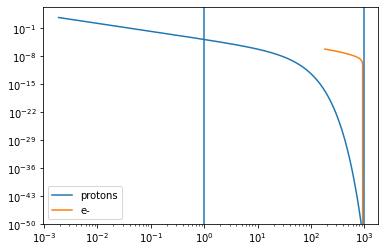

In [18]:
y=j.emitters_distribution.n_gamma_p
x=j.emitters_distribution.gamma_p*(const.c**2*const.m_p).to('TeV')
plt.loglog(x,y,label='protons')
y=j.emitters_distribution.n_gamma_e
x=j.emitters_distribution.gamma_e*(const.c**2*const.m_p).to('TeV')
plt.loglog(x,y,label='e-')

plt.axvline(1000)
plt.axvline(1)
plt.legend()
plt.ylim(1E-50,None)

(1e-50, 27607.37143392456)

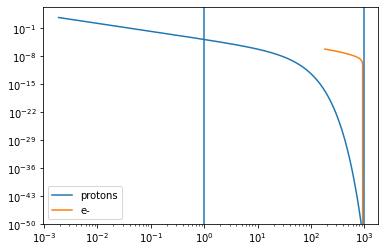

In [7]:
jetkernel.CooolingEquilibrium(j._blob,1E16/3E10)
y=j.emitters_distribution.n_gamma_p
x=j.emitters_distribution.gamma_p*(const.c**2*const.m_p).to('TeV')
plt.loglog(x,y,label='protons')
y=j.emitters_distribution.n_gamma_e
x=j.emitters_distribution.gamma_e*(const.c**2*const.m_p).to('TeV')
plt.loglog(x,y,label='e-')

plt.axvline(1000)
plt.axvline(1)
plt.legend()
plt.ylim(1E-50,None)

/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset-1.2.0-py3.8-macosx-10.9-x86_64.egg/jetset/jet_spectral_components.py:197: RuntimeWarning: divide by zero encountered in log10
  f_interp = interpolate.interp1d(log10(x), log10(y), bounds_error=False, kind=interp)


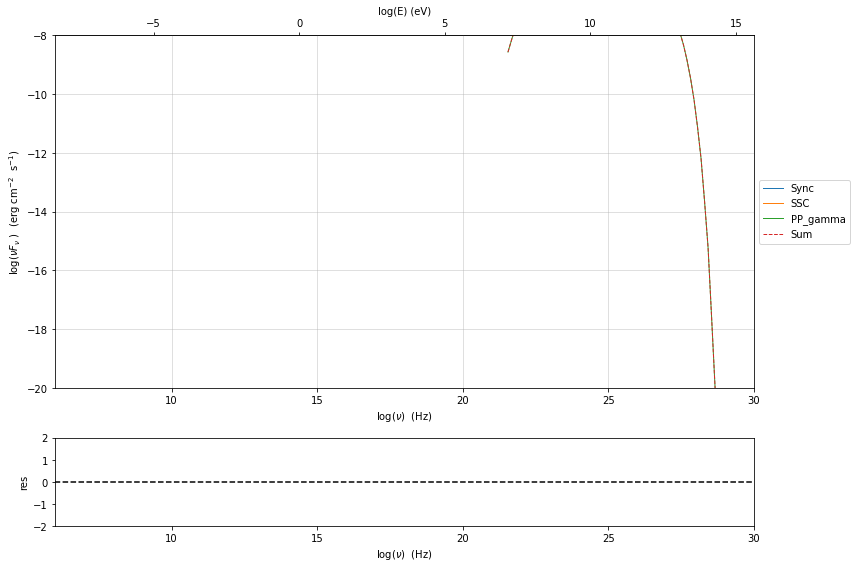

In [9]:
j.eval()
p=j.plot_model()


In [15]:
j._blob.g

0.9990388294313726

(1e-50, 1.0618501458514672e+19)

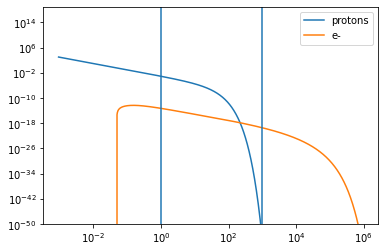

In [19]:
y=j.emitters_distribution.n_gamma_p
x=j.emitters_distribution.gamma_p*(const.c**2*const.m_p).to('TeV')
plt.loglog(x,y,label='protons')
y=j.emitters_distribution.n_gamma_e
x=j.emitters_distribution.gamma_e*(const.c**2*const.m_p).to('TeV')
plt.loglog(x,y,label='e-')

plt.axvline(1000)
plt.axvline(1)
plt.legend()
plt.ylim(1E-50,None)

==> Init_Np_Ne_pp


(0.0, 9.0)

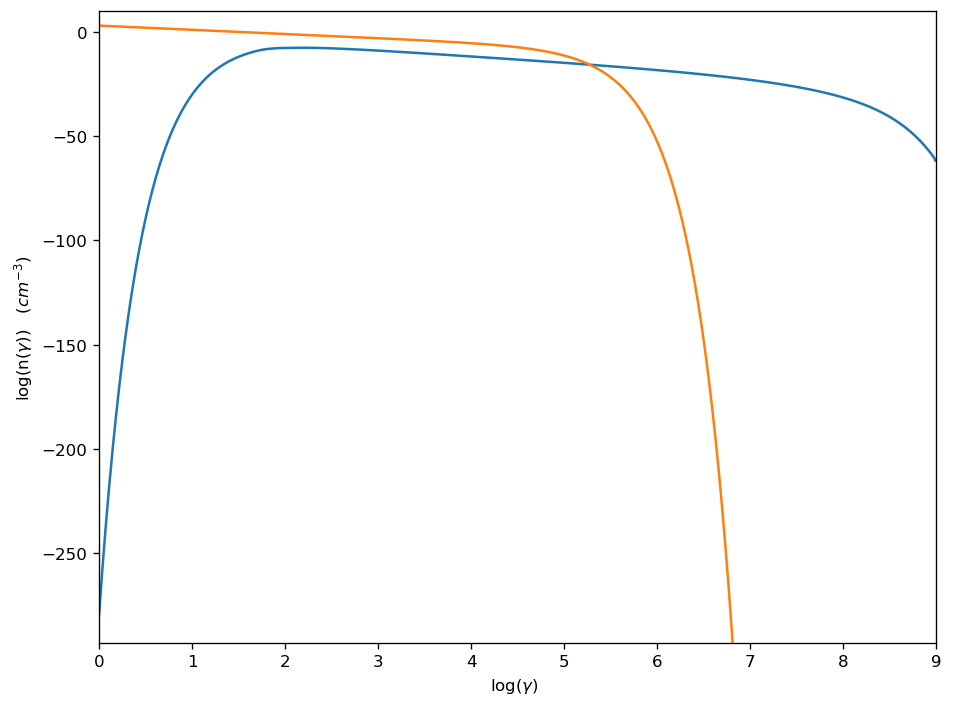

In [19]:
p=j.emitters_distribution.plot()
p.ax.set_ylim(None,10)
p.ax.set_xlim(0,9)

In [45]:
x=j.emitters_distribution.gamma_e
y=j.emitters_distribution.n_gamma_
m=x>1E12/938E6
print(np.trapz(y[m],x[m]**2)*(const.c**2*const.m_p).to('erg'))
print('%e'%x[m].min(),m)

AttributeError: 'JetkernelEmittersDistribution' object has no attribute 'n_gamma_'

In [145]:
1000/(const.c**2*const.m_p).to('TeV'),j.parameters.gamma_cut.val,1E12/938E6,x[m].min()

(<Quantity 1065788.92478889 1 / TeV>,
 1066098.0810234542,
 1066.0980810234541,
 1.021158714696652)

In [148]:
x[x>1E12/938E6].min()

1079.178409377536

In [8]:
j.energetic_report()

-----------------------------------------------------------------------------------------
jet eneregetic report:
     name                   type               units        val     
-------------- ----------------------------- --------- -------------
           U_e Energy dens. blob rest. frame erg / cm3  4.944831e-11
      U_p_cold Energy dens. blob rest. frame erg / cm3  1.503276e-03
           U_B Energy dens. blob rest. frame erg / cm3  3.978874e-04
           U_p Energy dens. blob rest. frame erg / cm3  2.119494e+00
    U_p_target Energy dens. blob rest. frame erg / cm3 2.215543e-314
       U_Synch Energy dens. blob rest. frame erg / cm3  1.469628e-11
   U_Synch_DRF Energy dens. disk rest. frame erg / cm3  1.469628e-11
        U_Disk Energy dens. blob rest. frame erg / cm3  0.000000e+00
         U_BLR Energy dens. blob rest. frame erg / cm3  0.000000e+00
          U_DT Energy dens. blob rest. frame erg / cm3  0.000000e+00
         U_CMB Energy dens. blob rest. frame erg / cm3  0.0

In [75]:
jetkernel.erg_to_TeV

0.6241512

In [10]:
j.emitters_distribution.update()

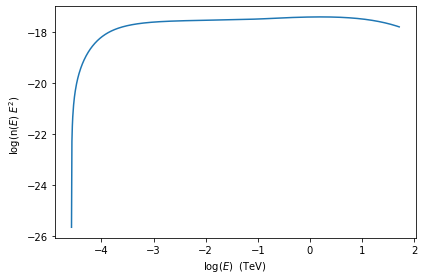

In [51]:
j.emitters_distribution.plot2p(energy_unit='TeV')

In [14]:
from astropy import units as u
from astropy import constants as const


In [44]:
#ng=nH
#ns=4nH

#vs= 300 km/s 3E7 cm/s assumed constant
#vd= 200 km/s ????
#hd= 100 pc
#omega 2-2.5 Eq. 8 Lamastra 2017
#Mach nomber

def N_H(N_H0,r):
    """
    -N_H0 1/cm^3
    -r  cm
    """
    
    return N_H0/(r*r)

def L_AGN(M_BH_dot,eta=0.1):
    """
    -M_BH_dot M_sun/year
    -eta eff
    """
    
    return (eta*M_BH_dot*const.M_sun.cgs*const.c.cgs).value


def L_SB_kin():
    
    return eps_SN*nu_SN*E_SN


def tau_pp(ng,Ep):
    """
    - ng 1/cm^3
    - Ep GeV
    return tau pp in seconds
    """
        sig_pp=30*(0.95 +0.06*np.log(Ep) )*1E-27 #cm-2
    return 1.0/(0.5*ng*sig_pp*const.c.to('cm s-1')).value
    
def tau_dyn(Rs,vs):
    """
    - Rs cm
    - vs cm/s
    return tau dyn in seconds
    """
    return Rs/vs

def Rs(MachN,t,vd):
    """
    M 
    return 
    """
    return 0.9*M*vd*t
    
def B_ISM(Sigma_gas,a):
    """
    - Sigma_gas grams/cm^2
    - a index, range [0.4,1]
    return B ISM in Gauss
    """
    return 6*(Sigma_gas/0.0025)*1E6


def B_shock(ns,Ts,epsB):
    """
    - ns shocked gas density = 4nH
    - Ts shocked gas Temperature 
    return shock magnetic field
    """
    
    return np.sqrt(8*np.pi*ns*Ts*const.k_B.cgs.value)
    

    
    
def Ts(vs):
    """
    -vs shock velocity cm/s
    """
    
    return (3/16)*const.m_p.cgs.value*const.c.cgs.value**2/(const.k_B.cgs.value)
    
    
    
    
def N_p_pars(vs_kms,tau_age_kyrs,B_mug):
    
    return 0.5*(vs_kms/1000)**2*tau_age_kyrs*B_mug/(const.m_p*const.c**2).to('TeV').value

def eval_t_inj(L_kin,N_H,R):
    pass

def eval_Rho_R(R,alpha_index):
    return R**(-alpha_index)

In [45]:
const.k_B.cgs

<Quantity 1.380649e-16 erg / K>

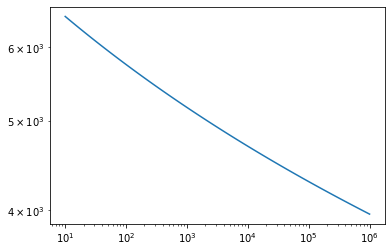

In [48]:
Ep=np.logspace(1,6,100)
plt.loglog(Ep,tau_pp(1E4,Ep)/86400/365)


In [169]:
N_p_pars(300,1000,50)

2398025.0807750127

In [131]:
def rho_g_2(R,Lb,Rvir):
    rg=np.zeros(R.size)
    rho_0=1000*const.m_p.to('g').value*(Lb/(1E45))**(1/3)
    msk=R<Rvir
    rg[msk]=rho_0/(1+(R[msk]/(100*const.pc.to('cm').value))**2)
    rg[~msk]=rho_0/(1+(Rvir/(100*const.pc.to('cm').value))**2)
    return rg/const.m_p.to('g').value

def rho_g_1(R,Lb,Rvir):
    Rdisk=0.04*Rvir
    rg=np.zeros(R.size)
    rho_0=1000*const.m_p.to('g').value*(Lb/(1E45))**(1/3)
    msk=R<Rdisk
    msk1=R>Rvir
    rg[msk] = rho_0/(1+(R[msk]/(100*const.pc.to('cm').value))**2)
    rg[~msk]= rho_0/(1+(Rdisk/(100*const.pc.to('cm').value))**2)*(R[~msk]/Rdisk)**-3.95
    rg[msk1]= rho_0/(1+(Rvir/(100*const.pc.to('cm').value))**2)*(Rvir/Rdisk)**-3.95
    return rg/const.m_p.to('g').value

(1e-06, 100000.0)

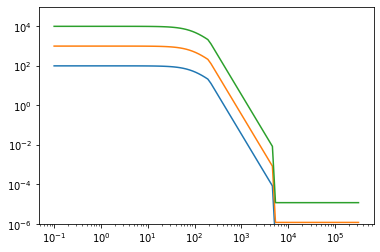

In [135]:
R=np.logspace(-1,5.5,100)*u.pc.to('cm')
plt.loglog(R/const.pc.to('cm'),rho_g_1(R,1E42,5000*const.pc.to('cm').value))
plt.loglog(R/const.pc.to('cm'),rho_g_1(R,1E45,5000*const.pc.to('cm').value))
plt.loglog(R/const.pc.to('cm'),rho_g_1(R,1E48,5000*const.pc.to('cm').value))

plt.ylim(1E-6,1E5)

In [73]:
(100*const.pc.to('km')/(1000*u.km/u.s)).to('yr')/1E5

<Quantity 0.97779222 yr>

In [78]:
tau_pp(1E4,10)*u.s.to('yr')/1E5

0.06475797605229375

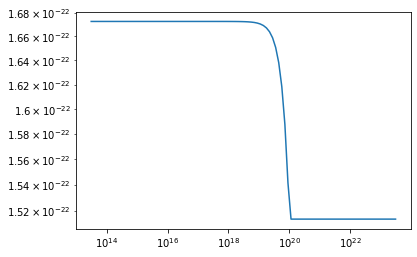

In [13]:
from jetset.jet_model import Jetpp,Jet
from jetset.plot_sedfit import PlotSED
from jetset.model_manager import FitModel

from astropy import units as u


from jetset.template_2Dmodel import EBLAbsorptionTemplate
ebl_dominguez=EBLAbsorptionTemplate.from_name('Dominguez_2010')
ebl_finke=EBLAbsorptionTemplate.from_name('Finke_2010')
ebl_franceschini=EBLAbsorptionTemplate.from_name('Franceschini_2008')
p_index=1.9
jp=Jetpp(proton_distribution='plc',name='jet_pp',T_esc_e_second=None)
jp.parameters.z_cosm.val=z=0.0033
jp.parameters.R.val=100*u.pc.to('cm')
jp.parameters.beam_obj.val=1
jp.parameters.gamma_cut.val=1E5
jp.parameters.NH_pp.val=4*1E4
jp.parameters.N.val=0.1E-9

jp.parameters.p.val=2.0
jp.parameters.B.val=1
jp.parameters.gmin.val=1
jp.parameters.gmax.val=1E8
jp._blob.N0_e_pp_factor =1E1



==> _set_blob Init_Np_Ne_pp


==>Init lin_fun
==> T_esc_e_second 10292712505.353258


/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset-1.2.0-py3.8-macosx-10.9-x86_64.egg/jetset/model_manager.py:160: UserWarning: no cosmology defined, using default FlatLambdaCDM(name="Planck13", H0=67.8 km / (Mpc s), Om0=0.307, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0483)
  warnings.warn('no cosmology defined, using default %s'%self.cosmo)


==>update lin_fun
==> _set_blob Init_Np_Ne_pp
5.516639534505116e+44
==>Init lin_fun
==> T_esc_e_second 10292712505.353258
==>update lin_fun
==> _set_blob Init_Np_Ne_pp
9.80636425185256e+44
==>Init lin_fun
==> T_esc_e_second 10292712505.353258
==>update lin_fun
==> _set_blob Init_Np_Ne_pp
1.1148790789631726e+45


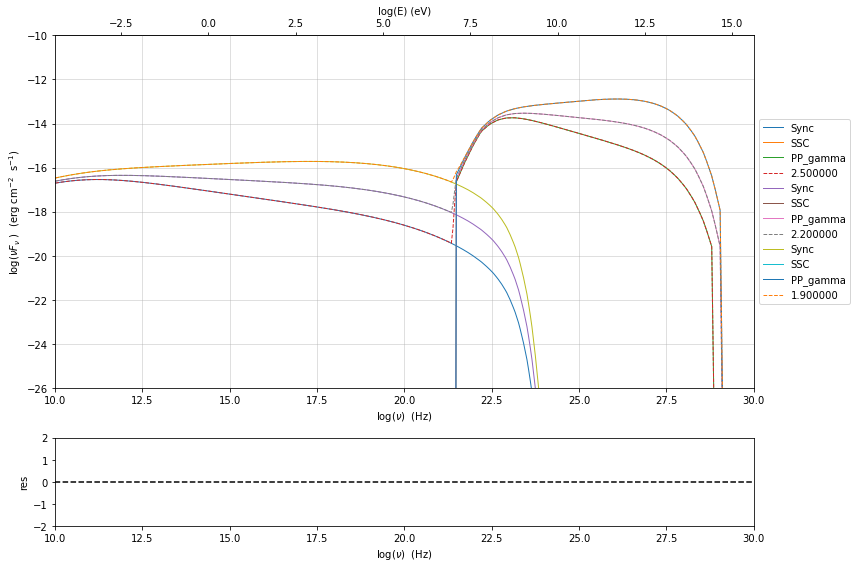

In [14]:
composite_model=FitModel(nu_size=500,name='EBL corrected')
composite_model.add_component(jp)
composite_model.add_component(ebl_franceschini)
ebl_franceschini.parameters.z_cosm.val=0.0033
composite_model.link_par(par_name='z_cosm',model_name_list=['jet_pp'],root_model_name='Franceschini_2008')
composite_model.composite_expr='jet_pp*Franceschini_2008'

composite_model.jet_pp.parameters.p.val=2.5
composite_model.eval()
p=composite_model.jet_pp.plot_model(label='%f'%composite_model.jet_pp.parameters.p.val)
jp.energetic_report(verbose=False)
print(jp.energetic_dict['U_p']*jp._blob.Vol_sphere/1E5)

composite_model.jet_pp.parameters.p.val=2.2
composite_model.eval()
p=composite_model.jet_pp.plot_model(plot_obj=p,label='%f'%composite_model.jet_pp.parameters.p.val)
jp.energetic_report(verbose=False)
print(jp.energetic_dict['U_p']*jp._blob.Vol_sphere/1E5)

composite_model.jet_pp.parameters.p.val=1.9
composite_model.eval()
p=composite_model.jet_pp.plot_model(plot_obj=p,label='%f'%composite_model.jet_pp.parameters.p.val)
jp.energetic_report(verbose=False)
print(jp.energetic_dict['U_p']*jp._blob.Vol_sphere/3E5)
p.rescale(x_min=10,y_min=-26,y_max=-10)

In [21]:
jp._blob.T_esc_e_second/1E9

10.292712505353258

In [10]:
from astropy import units as u

In [11]:
u.pc.to('cm')

3.0856775814671913e+18

In [21]:
jp.energetic_report(verbose=False)

In [4]:
E_tot_p=1.6E-3*jp.parameters.NH_pp.val*(4/3)*np.pi*jp.parameters.R.val**3
E_tot_p_k=1.6E-24*(100*1E5)**2*jp.parameters.NH_pp.val*(4/3)*np.pi*jp.parameters.R.val**3
print('%e'%E_tot_p)
print('%e'%E_tot_p_k)

vw=100*1E5 #(cm/s)
R_out=jp.parameters.R.val
t_out=R_out/vw
print('t_out=%e'%(t_out/(86400*365)))
print('%e'%(E_tot_p/1E42/(86400*365)))
print('t_inj=%e'%(E_tot_p_k/1E42/(86400*365)))

print('vw=%e'%vw)

1.809557e+61
1.809557e+54
t_out=9.512938e+05
5.738069e+11
t_inj=5.738069e+04
vw=1.000000e+07


==> _set_blob InitNe
==> _set_blob InitNe
==>Init lin_fun
==>update lin_fun
==> _set_blob InitNe


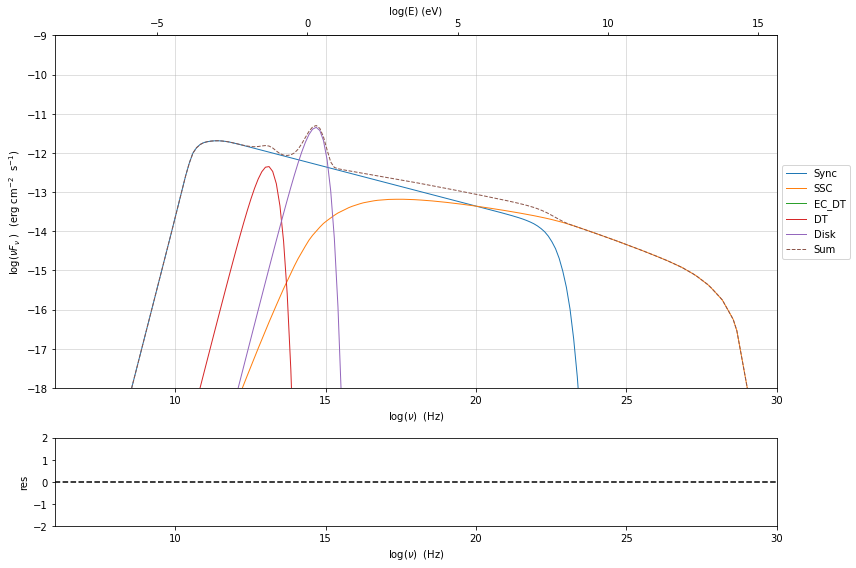

In [10]:
je=Jet(electron_distribution='bkn')
je.add_EC_component('EC_DT')
je.set_gamma_grid_size(200)
je.parameters.z_cosm.val=z=1.054000
je.parameters.R.val=5E17
je.parameters.R_H.val=3.5E23
je.parameters.L_Disk.val=4E46
je.parameters.T_Disk.val=12000
je.parameters.T_DT.val=300
je.parameters.R_DT.val=1.5E18
je.parameters.beam_obj.val=25
je.parameters.gamma_break.val=300
je.parameters.p.val=2.5
je.parameters.p_1.val=3.4
je.parameters.B.val=.05
je.parameters.N.val=6
je.parameters.gmin.val=50
je.parameters.gmax.val=1E8
je.eval()
p=je.plot_model(sed_data=None)
p.rescale(y_min=-18,y_max=-9)

In [11]:
%matplotlib inline
p=jp.plot_model(sed_data=sed_data)
p.add_model_plot(j)

NameError: name 'jp' is not defined

In [5]:
1.6E-3*jp.parameters.NH_pp.val*(4/3)*np.pi*jp.parameters.R.val**3

1.809557368467721e+61

In [100]:
j=Jet()

In [101]:
j.show_model()


-------------------------------------------------------------------------------------------------------------------
jet model description
-------------------------------------------------------------------------------------------------------------------
name: jet_leptonic  

electrons distribution:
 type: pl  
 gamma energy grid size:  1001
 gmin grid : 2.000000e+00
 gmax grid : 1.000000e+06
 normalization  True
 log-values  False

radiative fields:
 seed photons grid size:  100
 IC emission grid size:  50
 source emissivity lower bound :  1.000000e-120
 spectral components:
   name:Sum, state: on
   name:Sync, state: self-abs
   name:SSC, state: on
external fields transformation method: blob

SED info:
 nu grid size :200
 nu mix (Hz): 1.000000e+06
 nu max (Hz): 1.000000e+30

flux plot lower bound   :  1.000000e-120

 model name    name         par type           units          val      phys. bound. min phys. bound. max  log  frozen
------------ -------- ------------------- ----------

In [133]:
j.set_IC_nu_size(300)
j.set_gamma_grid_size(100)
j.spectral_components.Sync.state='on'

In [134]:
%prun j.eval()

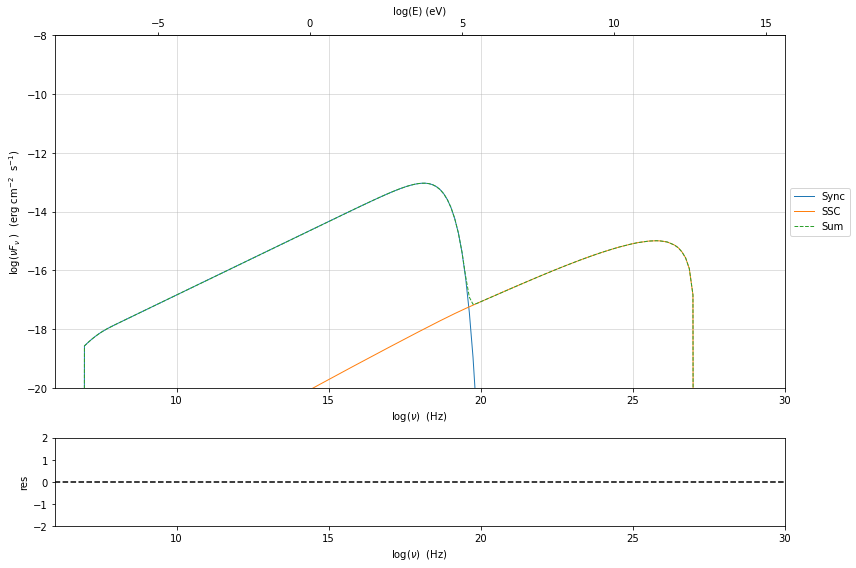

In [135]:
j.plot_model()


-------------------------------------------------------------------------------------------------------------------
jet model description
-------------------------------------------------------------------------------------------------------------------
name: jet_hadronic_pp  

protons distribution:
 type: plc  
 gamma energy grid size:  201
 gmin grid : 2.000000e+00
 gmax grid : 1.000000e+08
 normalization  True
 log-values  False

radiative fields:
 seed photons grid size:  100
 IC emission grid size:  100
 source emissivity lower bound :  1.000000e-120
 spectral components:
   name:Sum, state: on
   name:Sync, state: self-abs
   name:SSC, state: on
   name:PP_gamma, state: on
   name:PP_neutrino_tot, state: on
   name:PP_neutrino_mu, state: on
   name:PP_neutrino_e, state: on
   name:Bremss_ep, state: on
external fields transformation method: blob

SED info:
 nu grid size jetkernel: 1000
 nu grid size: 500
 nu mix (Hz): 1.000000e+06
 nu max (Hz): 1.000000e+30

flux plot lower bound

model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
str15,str9,str19,object,float64,float64,float64,bool,bool
jet_hadronic_pp,R,region_size,cm,5.000000e+15,1.000000e+03,1.000000e+30,False,False
jet_hadronic_pp,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_hadronic_pp,B,magnetic_field,gauss,8.000000e+01,0.000000e+00,--,False,False
jet_hadronic_pp,beam_obj,beaming,lorentz-factor*,1.000000e+01,1.000000e-04,--,False,False
jet_hadronic_pp,z_cosm,redshift,,1.000000e-01,0.000000e+00,--,False,False
jet_hadronic_pp,gmin,low-energy-cut-off,lorentz-factor*,2.000000e+00,1.000000e+00,1.000000e+09,False,False
jet_hadronic_pp,gmax,high-energy-cut-off,lorentz-factor*,1.000000e+08,1.000000e+00,1.000000e+15,False,False
jet_hadronic_pp,N,emitters_density,1 / cm3,1.000000e+01,0.000000e+00,--,False,False
jet_hadronic_pp,NH_pp,target_density,1 / cm3,1.000000e+10,0.000000e+00,--,False,False


-------------------------------------------------------------------------------------------------------------------


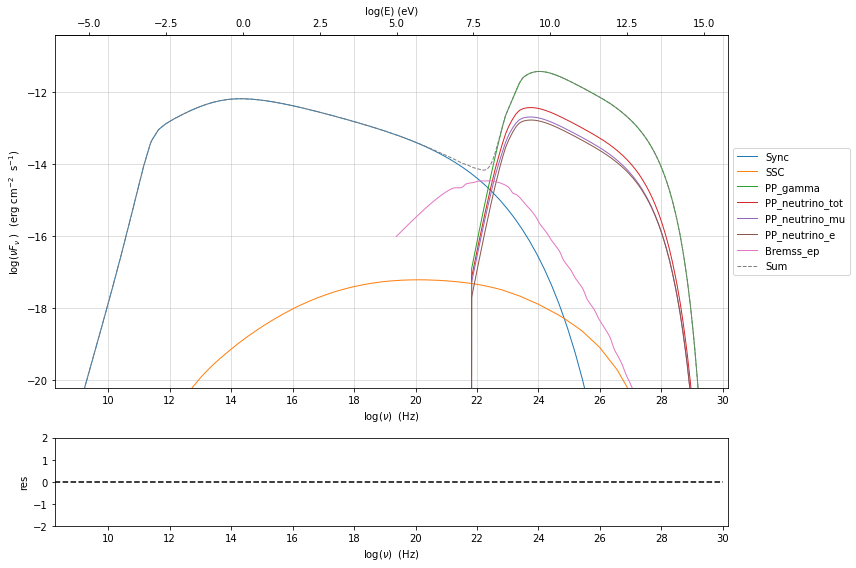

In [1]:
from jetset.jet_model import Jet
j = Jet(proton_distribution='plc')
j.parameters.gmin.val = 2
j.parameters.gmax.val = 1E8
j.parameters.NH_pp.val = 1E10
j.parameters.N.val = 1E1
j.parameters.B.val = 80

j.parameters.p.val = 2.5
j.eval()
j.show_model()
sum1=j.spectral_components.Sum.SED.nuFnu

j.plot_model()


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
str15,str9,str19,object,float64,float64,float64,bool,bool
jet_hadronic_pp,gmin,low-energy-cut-off,lorentz-factor*,2.000000e+00,1.000000e+00,1.000000e+09,False,False
jet_hadronic_pp,gmax,high-energy-cut-off,lorentz-factor*,1.000000e+08,1.000000e+00,1.000000e+15,False,False
jet_hadronic_pp,N,emitters_density,1 / cm3,1.000000e+01,0.000000e+00,--,False,False
jet_hadronic_pp,NH_pp,target_density,1 / cm3,1.000000e+10,0.000000e+00,--,False,False
jet_hadronic_pp,gamma_cut,turn-over-energy,lorentz-factor*,1.000000e+04,1.000000e+00,1.000000e+09,False,False
jet_hadronic_pp,p,LE_spectral_slope,,2.500000e+00,-1.000000e+01,1.000000e+01,False,False
jet_hadronic_pp,R,region_size,cm,5.000000e+15,1.000000e+03,1.000000e+30,False,False
jet_hadronic_pp,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_hadronic_pp,B,magnetic_field,gauss,8.000000e+01,0.000000e+00,--,False,False


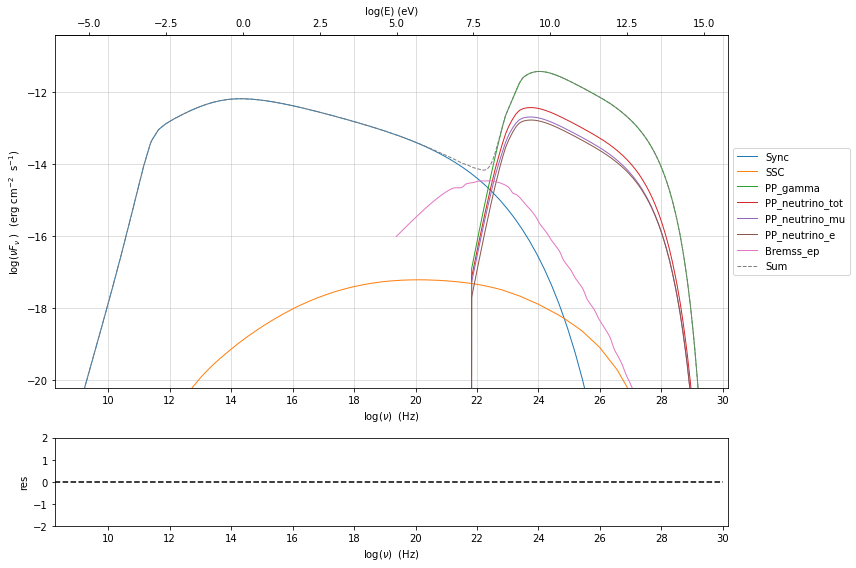

In [2]:
j.save_model('test_jet_hadronic.pkl')
j_new = Jet.load_model('test_jet_hadronic.pkl')
j_new.eval()
j_new.plot_model()

sum2 = j_new.spectral_components.Sum.SED.nuFnu
np.testing.assert_allclose(sum2,sum1, rtol=1E-5)

In [20]:
j_new._blob.T_esc_e_second

6.93575010000274e-310

In [5]:
x=sum2/sum1

In [7]:
x.min()

<Quantity 1.5479709e-108>